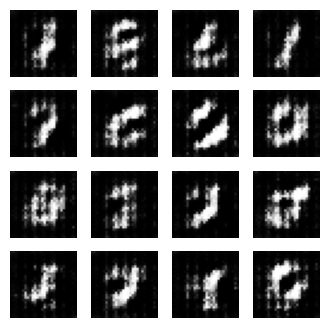

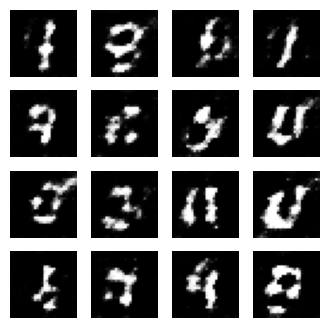

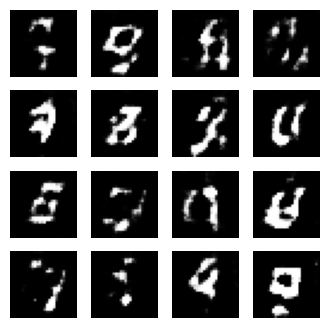

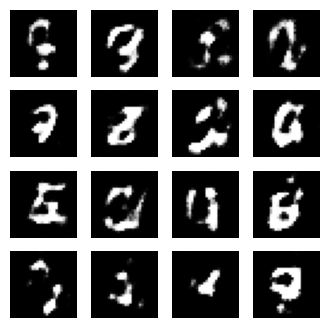

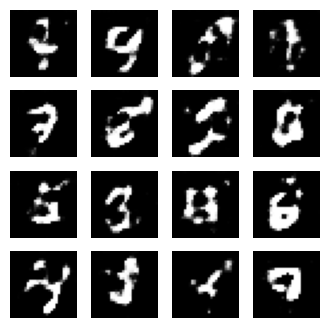

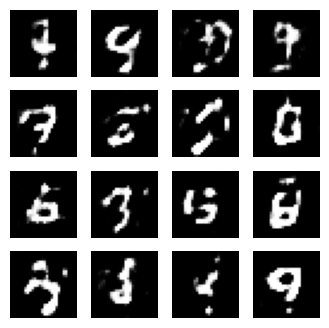

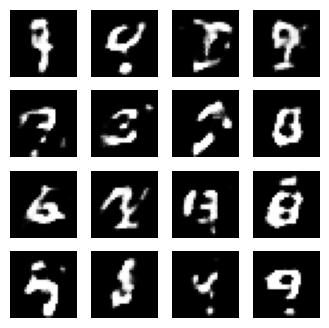

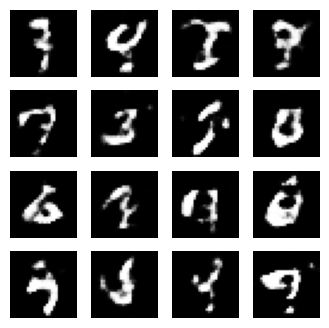

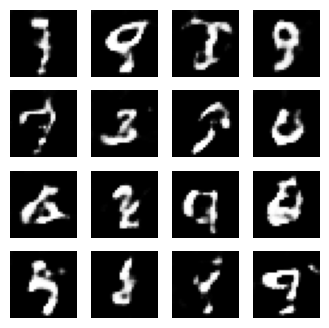

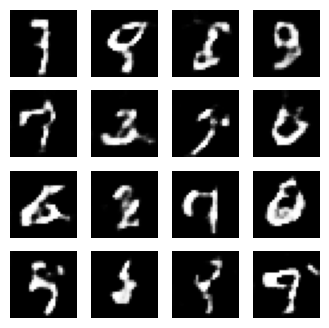

In [3]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess the MNIST dataset
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_train = (x_train - 127.5) / 127.5  # Normalize the images to [-1, 1]

# Define the generator model
def build_generator():
    model = tf.keras.Sequential([
        layers.Dense(7 * 7 * 64, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Reshape((7, 7, 64)),

        layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

# Define the discriminator model
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

# Define the discriminator and generator
discriminator = build_discriminator()
generator = build_generator()

# Define the loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Discriminator loss function
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Generator loss function
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Define the optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Training parameters
EPOCHS = 10
noise_dim = 100
num_examples_to_generate = 16
BATCH_SIZE = 64

# Generate noise for testing
test_noise = tf.random.normal([num_examples_to_generate, noise_dim])

# Training loop
for epoch in range(EPOCHS):
    for i in range(x_train.shape[0] // BATCH_SIZE):
        # Train discriminator
        noise = tf.random.normal([BATCH_SIZE, noise_dim])
        with tf.GradientTape() as disc_tape:
            generated_images = generator(noise, training=True)
            real_output = discriminator(x_train[i * BATCH_SIZE: (i + 1) * BATCH_SIZE], training=True)
            fake_output = discriminator(generated_images, training=True)
            disc_loss = discriminator_loss(real_output, fake_output)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

        # Train generator
        with tf.GradientTape() as gen_tape:
            noise = tf.random.normal([BATCH_SIZE, noise_dim])
            generated_images = generator(noise, training=True)
            fake_output = discriminator(generated_images, training=True)
            gen_loss = generator_loss(fake_output)
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    # Generate images for visualization
    if (epoch + 1) % 1 == 0:
        generated_images = generator(test_noise, training=False)
        # Plot images
        plt.figure(figsize=(4, 4))
        for i in range(generated_images.shape[0]):
            plt.subplot(4, 4, i + 1)
            plt.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
            plt.axis('off')
        plt.show()
